# Clustering of Seismic Attributes using K-Means algorithm in Sagemaker

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Define SEGY read function](#Define-SEGY-read-function)
  3. [Read SEGY data from S3](#Read-SEGY-data-from-S3)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Prediction](#Prediction)
6. [Write clustering results to SEGY format and upload to S3 ](#Write-clustering-results-to-SEGY-format-and-upload-to-S3 )

## Introduction

This notebook demonstrates a classification problem, specifically of seismic attributes. In areas where only seismic data is available with not enogh well data, there is no ground truth to do a supervised learning. A method of consideration for such cases can be "clustering", and in particular, the method that we'll look at today is called k-means clustering. In this method, each point belongs to the cluster with the closest mean, and the data is partitioned into a number of clusters that is specified when framing the problem. The idea here is to use clustering to highlight features of interest such as geo anomalies (salt, fault, channels, etc), or areas that might have certain rock/ fluid properties (high porosity, high hydrocanbon saturation etc).  

We will select a number of seismic attributes that are stored as SEGY files on s3, resize, and use them in the clustering algorithm. These are the seismic attributes available on s3:

    - Cosine phase
    - First derivative
    - Instantaneous Frequency
    - RMS Amplitude
    - Semblance
    - Original seismic data

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook.  See the documentation if you want to specify  a different role
1. The S3 bucket name and locations that you want to use for training and model data.

In [131]:
from sagemaker import get_execution_role

role = get_execution_role()

### Define SEGY read function

Here we will define a function using segyio package to read 3D SEGY files. segyio package can be installed using simple pip installation (currently commented below).

In [240]:
#!pip install segyio

import segyio
import numpy as np
import matplotlib.pyplot as plt
spec = segyio.spec()

def segy_decomp(segy_file, plot_data = False, read_direc='xline', inp_res = np.float32):
    # segy_file: filename of the segy-cube to be imported
    # plot_data: boolean that determines if a random xline should be plotted to test the reading
    # read_direc: which way the SEGY-cube should be read; 'xline', or 'inline'
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)

    # Make an empty object to hold the output data
    print('Starting SEG-Y decompressor')
    output = segyio.spec()

    # open the segyfile and start decomposing it
    with segyio.open(segy_file, "r" ) as segyfile:
        # Memory map file for faster reading (especially if file is big...)
        segyfile.mmap()

        # Store some initial object attributes
        output.inl_start = segyfile.ilines[0]
        output.inl_end = segyfile.ilines[-1]
        output.inl_step = segyfile.ilines[1] - segyfile.ilines[0]

        output.xl_start = segyfile.xlines[0]
        output.xl_end = segyfile.xlines[-1]
#        print('output.inl_step========',output.inl_step)
        if output.xl_end==0:
            output.xl_step = 1
        else:   output.xl_step = segyfile.xlines[1] - segyfile.xlines[0]
                
        output.t_start = int(segyfile.samples[0])
        output.t_end = int(segyfile.samples[-1])
        output.t_step = int(segyfile.samples[1] - segyfile.samples[0])


        # Pre-allocate a numpy array that holds the SEGY-cube
        output.data = np.empty((segyfile.xline.len,segyfile.iline.len,\
                        (output.t_end - output.t_start)//output.t_step+1), dtype = np.float32)

        # Read the entire cube line by line in the desired direction
        if read_direc == 'inline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for il_index in range(segyfile.xline.len):
                output.data[il_index,:,:] = segyfile.iline[segyfile.ilines[il_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'xline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for xl_index in range(segyfile.iline.len):
                output.data[:,xl_index,:] = segyfile.xline[segyfile.xlines[xl_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'full':
            ## NOTE: 'full' for some reason invokes float32 data
            # Potentially time this to find the "fast" direction
            #start = time.time()
            output.data = segyio.tools.cube(segy_file)
            #end = time.time()
            #print(end - start)
        else:
            print('Define reading direction(read_direc) using either ''inline'', ''xline'', or ''full''')


        # Convert the numpy array to span between -127 and 127 and convert to the desired format
#         factor = 127/np.amax(np.absolute(output.data))
#         if inp_res == np.float32:
#             output.data = (output.data*factor)
#         else:
#             output.data = (output.data*factor).astype(dtype = inp_res)factor

        # If sepcified, plot a given x-line to test the read data
        if plot_data:
            # Take a given xline
            data = output.data[:,0,:]
            # Plot the read x-line
            plt.imshow(data.T,interpolation="nearest", cmap="gray")
            plt.colorbar()
            plt.show()


    # Return the output object
    print('Finished using the SEG-Y decompressor')
    return output


### Read SEGY data from S3

We will read the first 3 seismic files from S3 into a python array (one at a time), cut them into smaller cubes, reshape them into a 1D array, and save them to a variable called "att". After saving, we remove each segy volume from disk before moving to the next volume.  


['segy/3CRNRS_WZ.segy',
 'segy/3CRNRS_WZ_COSPHASE.segy',
 'segy/3CRNRS_WZ_fristderivative.segy',
 'segy/3CRNRS_WZ_instafreq.segy',
 'segy/3CRNRS_WZ_rmsamp.segy',
 'segy/3CRNRS_WZ_semblance.segy']

6

['3CRNRS_WZ_instafreq.segy',
 '3CRNRS_WZ_rmsamp.segy',
 '3CRNRS_WZ_semblance.segy']

Starting SEG-Y decompressor


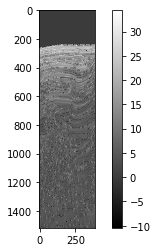

Finished using the SEG-Y decompressor
[ 20.93317986  22.08268547  23.14143944 ...,   3.84365463   3.08240223
   2.65152645]
Starting SEG-Y decompressor


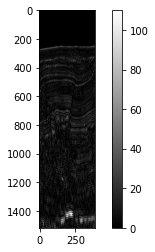

Finished using the SEG-Y decompressor
[ 4.41535425  4.57499695  4.41535378 ...,  3.85108042  4.54877901
  5.14124012]
Starting SEG-Y decompressor


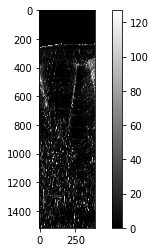

Finished using the SEG-Y decompressor
[ 10.95767498  12.67353725  11.46235943 ...,  10.87054634   9.11316681
   7.29800606]


In [134]:
import boto3
import os
import glob
%matplotlib inline

BUCKET_NAME = 'sdu-machine-learning'  # bucket name where data is stored
s3 = boto3.resource('s3')


bucket_list = []
for key in s3.Bucket(BUCKET_NAME).objects.all():
    bucket_list.append(key.key)
    
samp_sgy = [s for s in bucket_list if '.segy' in s and '.xml' not in s]
display(samp_sgy)

display(len(samp_sgy))
FILE_NAME = [s.split("/")[-1] for s in samp_sgy]
FILE_NAME = FILE_NAME[-3:]  # keep only the last 3 attributes: Freq, Semblance, and RMSAMp
display(FILE_NAME)


PREFIX = 'segy'                            # Location of the file within the S3 bucket

new_il_start = 20   # starting number for inlines for the new seismic cube
new_xl_start = 20   # starting number for xlines for the new seismic cube
new_ts_start = 300  # starting number for vertical samples for the new seismic cube

new_il_end = 200    # end number for inlines for the new seismic cube
new_xl_end = 200    # end number for xlines for the new seismic cube
new_ts_end = 1200    # end number for vertical samples for the new seismic cube

#num_att = len(sgy_names)-3  # Number of attributes to be used for the clustering
#num_att = len(FILE_NAME)-3  # Number of attributes to be used for the clustering
num_att = len(FILE_NAME)  # Number of attributes to be used for the clustering

att = np.zeros(((new_il_end - new_il_start)*(new_xl_end - new_xl_start)*(new_ts_end - new_ts_start),num_att))

for i in range(num_att):
    url = '{}/{}'.format(PREFIX, FILE_NAME[i]) 
    s3.Bucket(BUCKET_NAME).download_file(url, FILE_NAME[i])
    segy_obj = segy_decomp(segy_file = FILE_NAME[i],
               plot_data = True,
               read_direc = 'xline',
               inp_res = np.float32 ) 
    
    data_sei = segy_obj.data
    data_sei = data_sei[new_il_start:new_il_end,new_xl_start:new_xl_end,new_ts_start:new_ts_end]
    data_sei = data_sei.reshape(data_sei.shape[0]*data_sei.shape[1]*data_sei.shape[2])
    print(data_sei)
    att[:,i]=data_sei
    for i in glob.glob("*.segy"):
        os.remove(i) 
        
att=np.float32(att)        

In [135]:
print(att.shape) # check the size of attributes array

(29160000, 3)


## Training the K-Means model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the k-means training algorithm.  But Amazon SageMaker's k-means has been tested on, and scales well with, multi-terabyte datasets.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 7 and 11 minutes.

In [136]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example_shellData/output'.format(bucket)
prefix = 'kmeans_example_shellData/output'

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=4,
                data_location=data_location)

training data will be uploaded to: s3://sdu-sagemaker-workshop/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sdu-sagemaker-workshop/kmeans_example_shellData/output


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-401213972244


In [137]:
%%time
att1=att[1:10000]
kmeans.fit(kmeans.record_set(att1))

INFO:sagemaker:Creating training-job with name: kmeans-2018-03-11-21-08-07-711


............................................................................
Docker entrypoint called with argument(s): train
[03/11/2018 21:14:20 INFO 140240104392512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[03/11/2018 21:14:20 INFO 140240104392512] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'3', u'mini_batch_size': u'500', u'k': u'4', u'force_dense': u'True'}
[03/11/2018 21:14:20 INFO 14024

===== Job Complete =====
CPU times: user 820 ms, sys: 0 ns, total: 820 ms
Wall time: 8min 9s


## Set up hosting for the model
Now, we can deploy the model we just trained behind a real-time hosted endpoint.  This next step can take, on average, 7 to 11 minutes to complete.

In [138]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=3,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-03-11-21-30-42-889
INFO:sagemaker:Creating endpoint with name kmeans-2018-03-11-21-08-07-711


---------------------------------------------------------------------------------------------------------------------------!CPU times: user 508 ms, sys: 8 ms, total: 516 ms
Wall time: 10min 34s


## Prediction
Finally, we'll apply the trained clustering algorithm to the entire dataset. Let's generate a classification for the enitre data using the endpoint we just created.

In [142]:
##############################################################
###############       Batch Prediction       #################
##############################################################
import sys
import math

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):

        if offset+batch_size < items:
            print(offset)
            results = kmeans_predictor.predict(data[offset:(offset+batch_size)])
            clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in results]
            arrs.extend(clusters)
        else:
            results = kmeans_predictor.predict(data[offset:items])
            clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in results]
            arrs.extend(clusters)
            sys.stdout.write('.')
    return(arrs)


clusters1 = batch_predict(att, 1000)

##############################################################




0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1164000
1165000
1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000


2190000
2191000
2192000
2193000
2194000
2195000
2196000
2197000
2198000
2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000
2314000


3215000
3216000
3217000
3218000
3219000
3220000
3221000
3222000
3223000
3224000
3225000
3226000
3227000
3228000
3229000
3230000
3231000
3232000
3233000
3234000
3235000
3236000
3237000
3238000
3239000
3240000
3241000
3242000
3243000
3244000
3245000
3246000
3247000
3248000
3249000
3250000
3251000
3252000
3253000
3254000
3255000
3256000
3257000
3258000
3259000
3260000
3261000
3262000
3263000
3264000
3265000
3266000
3267000
3268000
3269000
3270000
3271000
3272000
3273000
3274000
3275000
3276000
3277000
3278000
3279000
3280000
3281000
3282000
3283000
3284000
3285000
3286000
3287000
3288000
3289000
3290000
3291000
3292000
3293000
3294000
3295000
3296000
3297000
3298000
3299000
3300000
3301000
3302000
3303000
3304000
3305000
3306000
3307000
3308000
3309000
3310000
3311000
3312000
3313000
3314000
3315000
3316000
3317000
3318000
3319000
3320000
3321000
3322000
3323000
3324000
3325000
3326000
3327000
3328000
3329000
3330000
3331000
3332000
3333000
3334000
3335000
3336000
3337000
3338000
3339000


4241000
4242000
4243000
4244000
4245000
4246000
4247000
4248000
4249000
4250000
4251000
4252000
4253000
4254000
4255000
4256000
4257000
4258000
4259000
4260000
4261000
4262000
4263000
4264000
4265000
4266000
4267000
4268000
4269000
4270000
4271000
4272000
4273000
4274000
4275000
4276000
4277000
4278000
4279000
4280000
4281000
4282000
4283000
4284000
4285000
4286000
4287000
4288000
4289000
4290000
4291000
4292000
4293000
4294000
4295000
4296000
4297000
4298000
4299000
4300000
4301000
4302000
4303000
4304000
4305000
4306000
4307000
4308000
4309000
4310000
4311000
4312000
4313000
4314000
4315000
4316000
4317000
4318000
4319000
4320000
4321000
4322000
4323000
4324000
4325000
4326000
4327000
4328000
4329000
4330000
4331000
4332000
4333000
4334000
4335000
4336000
4337000
4338000
4339000
4340000
4341000
4342000
4343000
4344000
4345000
4346000
4347000
4348000
4349000
4350000
4351000
4352000
4353000
4354000
4355000
4356000
4357000
4358000
4359000
4360000
4361000
4362000
4363000
4364000
4365000


5266000
5267000
5268000
5269000
5270000
5271000
5272000
5273000
5274000
5275000
5276000
5277000
5278000
5279000
5280000
5281000
5282000
5283000
5284000
5285000
5286000
5287000
5288000
5289000
5290000
5291000
5292000
5293000
5294000
5295000
5296000
5297000
5298000
5299000
5300000
5301000
5302000
5303000
5304000
5305000
5306000
5307000
5308000
5309000
5310000
5311000
5312000
5313000
5314000
5315000
5316000
5317000
5318000
5319000
5320000
5321000
5322000
5323000
5324000
5325000
5326000
5327000
5328000
5329000
5330000
5331000
5332000
5333000
5334000
5335000
5336000
5337000
5338000
5339000
5340000
5341000
5342000
5343000
5344000
5345000
5346000
5347000
5348000
5349000
5350000
5351000
5352000
5353000
5354000
5355000
5356000
5357000
5358000
5359000
5360000
5361000
5362000
5363000
5364000
5365000
5366000
5367000
5368000
5369000
5370000
5371000
5372000
5373000
5374000
5375000
5376000
5377000
5378000
5379000
5380000
5381000
5382000
5383000
5384000
5385000
5386000
5387000
5388000
5389000
5390000


6292000
6293000
6294000
6295000
6296000
6297000
6298000
6299000
6300000
6301000
6302000
6303000
6304000
6305000
6306000
6307000
6308000
6309000
6310000
6311000
6312000
6313000
6314000
6315000
6316000
6317000
6318000
6319000
6320000
6321000
6322000
6323000
6324000
6325000
6326000
6327000
6328000
6329000
6330000
6331000
6332000
6333000
6334000
6335000
6336000
6337000
6338000
6339000
6340000
6341000
6342000
6343000
6344000
6345000
6346000
6347000
6348000
6349000
6350000
6351000
6352000
6353000
6354000
6355000
6356000
6357000
6358000
6359000
6360000
6361000
6362000
6363000
6364000
6365000
6366000
6367000
6368000
6369000
6370000
6371000
6372000
6373000
6374000
6375000
6376000
6377000
6378000
6379000
6380000
6381000
6382000
6383000
6384000
6385000
6386000
6387000
6388000
6389000
6390000
6391000
6392000
6393000
6394000
6395000
6396000
6397000
6398000
6399000
6400000
6401000
6402000
6403000
6404000
6405000
6406000
6407000
6408000
6409000
6410000
6411000
6412000
6413000
6414000
6415000
6416000


7317000
7318000
7319000
7320000
7321000
7322000
7323000
7324000
7325000
7326000
7327000
7328000
7329000
7330000
7331000
7332000
7333000
7334000
7335000
7336000
7337000
7338000
7339000
7340000
7341000
7342000
7343000
7344000
7345000
7346000
7347000
7348000
7349000
7350000
7351000
7352000
7353000
7354000
7355000
7356000
7357000
7358000
7359000
7360000
7361000
7362000
7363000
7364000
7365000
7366000
7367000
7368000
7369000
7370000
7371000
7372000
7373000
7374000
7375000
7376000
7377000
7378000
7379000
7380000
7381000
7382000
7383000
7384000
7385000
7386000
7387000
7388000
7389000
7390000
7391000
7392000
7393000
7394000
7395000
7396000
7397000
7398000
7399000
7400000
7401000
7402000
7403000
7404000
7405000
7406000
7407000
7408000
7409000
7410000
7411000
7412000
7413000
7414000
7415000
7416000
7417000
7418000
7419000
7420000
7421000
7422000
7423000
7424000
7425000
7426000
7427000
7428000
7429000
7430000
7431000
7432000
7433000
7434000
7435000
7436000
7437000
7438000
7439000
7440000
7441000


8343000
8344000
8345000
8346000
8347000
8348000
8349000
8350000
8351000
8352000
8353000
8354000
8355000
8356000
8357000
8358000
8359000
8360000
8361000
8362000
8363000
8364000
8365000
8366000
8367000
8368000
8369000
8370000
8371000
8372000
8373000
8374000
8375000
8376000
8377000
8378000
8379000
8380000
8381000
8382000
8383000
8384000
8385000
8386000
8387000
8388000
8389000
8390000
8391000
8392000
8393000
8394000
8395000
8396000
8397000
8398000
8399000
8400000
8401000
8402000
8403000
8404000
8405000
8406000
8407000
8408000
8409000
8410000
8411000
8412000
8413000
8414000
8415000
8416000
8417000
8418000
8419000
8420000
8421000
8422000
8423000
8424000
8425000
8426000
8427000
8428000
8429000
8430000
8431000
8432000
8433000
8434000
8435000
8436000
8437000
8438000
8439000
8440000
8441000
8442000
8443000
8444000
8445000
8446000
8447000
8448000
8449000
8450000
8451000
8452000
8453000
8454000
8455000
8456000
8457000
8458000
8459000
8460000
8461000
8462000
8463000
8464000
8465000
8466000
8467000


9368000
9369000
9370000
9371000
9372000
9373000
9374000
9375000
9376000
9377000
9378000
9379000
9380000
9381000
9382000
9383000
9384000
9385000
9386000
9387000
9388000
9389000
9390000
9391000
9392000
9393000
9394000
9395000
9396000
9397000
9398000
9399000
9400000
9401000
9402000
9403000
9404000
9405000
9406000
9407000
9408000
9409000
9410000
9411000
9412000
9413000
9414000
9415000
9416000
9417000
9418000
9419000
9420000
9421000
9422000
9423000
9424000
9425000
9426000
9427000
9428000
9429000
9430000
9431000
9432000
9433000
9434000
9435000
9436000
9437000
9438000
9439000
9440000
9441000
9442000
9443000
9444000
9445000
9446000
9447000
9448000
9449000
9450000
9451000
9452000
9453000
9454000
9455000
9456000
9457000
9458000
9459000
9460000
9461000
9462000
9463000
9464000
9465000
9466000
9467000
9468000
9469000
9470000
9471000
9472000
9473000
9474000
9475000
9476000
9477000
9478000
9479000
9480000
9481000
9482000
9483000
9484000
9485000
9486000
9487000
9488000
9489000
9490000
9491000
9492000


10349000
10350000
10351000
10352000
10353000
10354000
10355000
10356000
10357000
10358000
10359000
10360000
10361000
10362000
10363000
10364000
10365000
10366000
10367000
10368000
10369000
10370000
10371000
10372000
10373000
10374000
10375000
10376000
10377000
10378000
10379000
10380000
10381000
10382000
10383000
10384000
10385000
10386000
10387000
10388000
10389000
10390000
10391000
10392000
10393000
10394000
10395000
10396000
10397000
10398000
10399000
10400000
10401000
10402000
10403000
10404000
10405000
10406000
10407000
10408000
10409000
10410000
10411000
10412000
10413000
10414000
10415000
10416000
10417000
10418000
10419000
10420000
10421000
10422000
10423000
10424000
10425000
10426000
10427000
10428000
10429000
10430000
10431000
10432000
10433000
10434000
10435000
10436000
10437000
10438000
10439000
10440000
10441000
10442000
10443000
10444000
10445000
10446000
10447000
10448000
10449000
10450000
10451000
10452000
10453000
10454000
10455000
10456000
10457000
10458000
10459000
1

11260000
11261000
11262000
11263000
11264000
11265000
11266000
11267000
11268000
11269000
11270000
11271000
11272000
11273000
11274000
11275000
11276000
11277000
11278000
11279000
11280000
11281000
11282000
11283000
11284000
11285000
11286000
11287000
11288000
11289000
11290000
11291000
11292000
11293000
11294000
11295000
11296000
11297000
11298000
11299000
11300000
11301000
11302000
11303000
11304000
11305000
11306000
11307000
11308000
11309000
11310000
11311000
11312000
11313000
11314000
11315000
11316000
11317000
11318000
11319000
11320000
11321000
11322000
11323000
11324000
11325000
11326000
11327000
11328000
11329000
11330000
11331000
11332000
11333000
11334000
11335000
11336000
11337000
11338000
11339000
11340000
11341000
11342000
11343000
11344000
11345000
11346000
11347000
11348000
11349000
11350000
11351000
11352000
11353000
11354000
11355000
11356000
11357000
11358000
11359000
11360000
11361000
11362000
11363000
11364000
11365000
11366000
11367000
11368000
11369000
11370000
1

12172000
12173000
12174000
12175000
12176000
12177000
12178000
12179000
12180000
12181000
12182000
12183000
12184000
12185000
12186000
12187000
12188000
12189000
12190000
12191000
12192000
12193000
12194000
12195000
12196000
12197000
12198000
12199000
12200000
12201000
12202000
12203000
12204000
12205000
12206000
12207000
12208000
12209000
12210000
12211000
12212000
12213000
12214000
12215000
12216000
12217000
12218000
12219000
12220000
12221000
12222000
12223000
12224000
12225000
12226000
12227000
12228000
12229000
12230000
12231000
12232000
12233000
12234000
12235000
12236000
12237000
12238000
12239000
12240000
12241000
12242000
12243000
12244000
12245000
12246000
12247000
12248000
12249000
12250000
12251000
12252000
12253000
12254000
12255000
12256000
12257000
12258000
12259000
12260000
12261000
12262000
12263000
12264000
12265000
12266000
12267000
12268000
12269000
12270000
12271000
12272000
12273000
12274000
12275000
12276000
12277000
12278000
12279000
12280000
12281000
12282000
1

13083000
13084000
13085000
13086000
13087000
13088000
13089000
13090000
13091000
13092000
13093000
13094000
13095000
13096000
13097000
13098000
13099000
13100000
13101000
13102000
13103000
13104000
13105000
13106000
13107000
13108000
13109000
13110000
13111000
13112000
13113000
13114000
13115000
13116000
13117000
13118000
13119000
13120000
13121000
13122000
13123000
13124000
13125000
13126000
13127000
13128000
13129000
13130000
13131000
13132000
13133000
13134000
13135000
13136000
13137000
13138000
13139000
13140000
13141000
13142000
13143000
13144000
13145000
13146000
13147000
13148000
13149000
13150000
13151000
13152000
13153000
13154000
13155000
13156000
13157000
13158000
13159000
13160000
13161000
13162000
13163000
13164000
13165000
13166000
13167000
13168000
13169000
13170000
13171000
13172000
13173000
13174000
13175000
13176000
13177000
13178000
13179000
13180000
13181000
13182000
13183000
13184000
13185000
13186000
13187000
13188000
13189000
13190000
13191000
13192000
13193000
1

13995000
13996000
13997000
13998000
13999000
14000000
14001000
14002000
14003000
14004000
14005000
14006000
14007000
14008000
14009000
14010000
14011000
14012000
14013000
14014000
14015000
14016000
14017000
14018000
14019000
14020000
14021000
14022000
14023000
14024000
14025000
14026000
14027000
14028000
14029000
14030000
14031000
14032000
14033000
14034000
14035000
14036000
14037000
14038000
14039000
14040000
14041000
14042000
14043000
14044000
14045000
14046000
14047000
14048000
14049000
14050000
14051000
14052000
14053000
14054000
14055000
14056000
14057000
14058000
14059000
14060000
14061000
14062000
14063000
14064000
14065000
14066000
14067000
14068000
14069000
14070000
14071000
14072000
14073000
14074000
14075000
14076000
14077000
14078000
14079000
14080000
14081000
14082000
14083000
14084000
14085000
14086000
14087000
14088000
14089000
14090000
14091000
14092000
14093000
14094000
14095000
14096000
14097000
14098000
14099000
14100000
14101000
14102000
14103000
14104000
14105000
1

14907000
14908000
14909000
14910000
14911000
14912000
14913000
14914000
14915000
14916000
14917000
14918000
14919000
14920000
14921000
14922000
14923000
14924000
14925000
14926000
14927000
14928000
14929000
14930000
14931000
14932000
14933000
14934000
14935000
14936000
14937000
14938000
14939000
14940000
14941000
14942000
14943000
14944000
14945000
14946000
14947000
14948000
14949000
14950000
14951000
14952000
14953000
14954000
14955000
14956000
14957000
14958000
14959000
14960000
14961000
14962000
14963000
14964000
14965000
14966000
14967000
14968000
14969000
14970000
14971000
14972000
14973000
14974000
14975000
14976000
14977000
14978000
14979000
14980000
14981000
14982000
14983000
14984000
14985000
14986000
14987000
14988000
14989000
14990000
14991000
14992000
14993000
14994000
14995000
14996000
14997000
14998000
14999000
15000000
15001000
15002000
15003000
15004000
15005000
15006000
15007000
15008000
15009000
15010000
15011000
15012000
15013000
15014000
15015000
15016000
15017000
1

15819000
15820000
15821000
15822000
15823000
15824000
15825000
15826000
15827000
15828000
15829000
15830000
15831000
15832000
15833000
15834000
15835000
15836000
15837000
15838000
15839000
15840000
15841000
15842000
15843000
15844000
15845000
15846000
15847000
15848000
15849000
15850000
15851000
15852000
15853000
15854000
15855000
15856000
15857000
15858000
15859000
15860000
15861000
15862000
15863000
15864000
15865000
15866000
15867000
15868000
15869000
15870000
15871000
15872000
15873000
15874000
15875000
15876000
15877000
15878000
15879000
15880000
15881000
15882000
15883000
15884000
15885000
15886000
15887000
15888000
15889000
15890000
15891000
15892000
15893000
15894000
15895000
15896000
15897000
15898000
15899000
15900000
15901000
15902000
15903000
15904000
15905000
15906000
15907000
15908000
15909000
15910000
15911000
15912000
15913000
15914000
15915000
15916000
15917000
15918000
15919000
15920000
15921000
15922000
15923000
15924000
15925000
15926000
15927000
15928000
15929000
1

16730000
16731000
16732000
16733000
16734000
16735000
16736000
16737000
16738000
16739000
16740000
16741000
16742000
16743000
16744000
16745000
16746000
16747000
16748000
16749000
16750000
16751000
16752000
16753000
16754000
16755000
16756000
16757000
16758000
16759000
16760000
16761000
16762000
16763000
16764000
16765000
16766000
16767000
16768000
16769000
16770000
16771000
16772000
16773000
16774000
16775000
16776000
16777000
16778000
16779000
16780000
16781000
16782000
16783000
16784000
16785000
16786000
16787000
16788000
16789000
16790000
16791000
16792000
16793000
16794000
16795000
16796000
16797000
16798000
16799000
16800000
16801000
16802000
16803000
16804000
16805000
16806000
16807000
16808000
16809000
16810000
16811000
16812000
16813000
16814000
16815000
16816000
16817000
16818000
16819000
16820000
16821000
16822000
16823000
16824000
16825000
16826000
16827000
16828000
16829000
16830000
16831000
16832000
16833000
16834000
16835000
16836000
16837000
16838000
16839000
16840000
1

17641000
17642000
17643000
17644000
17645000
17646000
17647000
17648000
17649000
17650000
17651000
17652000
17653000
17654000
17655000
17656000
17657000
17658000
17659000
17660000
17661000
17662000
17663000
17664000
17665000
17666000
17667000
17668000
17669000
17670000
17671000
17672000
17673000
17674000
17675000
17676000
17677000
17678000
17679000
17680000
17681000
17682000
17683000
17684000
17685000
17686000
17687000
17688000
17689000
17690000
17691000
17692000
17693000
17694000
17695000
17696000
17697000
17698000
17699000
17700000
17701000
17702000
17703000
17704000
17705000
17706000
17707000
17708000
17709000
17710000
17711000
17712000
17713000
17714000
17715000
17716000
17717000
17718000
17719000
17720000
17721000
17722000
17723000
17724000
17725000
17726000
17727000
17728000
17729000
17730000
17731000
17732000
17733000
17734000
17735000
17736000
17737000
17738000
17739000
17740000
17741000
17742000
17743000
17744000
17745000
17746000
17747000
17748000
17749000
17750000
17751000
1

18553000
18554000
18555000
18556000
18557000
18558000
18559000
18560000
18561000
18562000
18563000
18564000
18565000
18566000
18567000
18568000
18569000
18570000
18571000
18572000
18573000
18574000
18575000
18576000
18577000
18578000
18579000
18580000
18581000
18582000
18583000
18584000
18585000
18586000
18587000
18588000
18589000
18590000
18591000
18592000
18593000
18594000
18595000
18596000
18597000
18598000
18599000
18600000
18601000
18602000
18603000
18604000
18605000
18606000
18607000
18608000
18609000
18610000
18611000
18612000
18613000
18614000
18615000
18616000
18617000
18618000
18619000
18620000
18621000
18622000
18623000
18624000
18625000
18626000
18627000
18628000
18629000
18630000
18631000
18632000
18633000
18634000
18635000
18636000
18637000
18638000
18639000
18640000
18641000
18642000
18643000
18644000
18645000
18646000
18647000
18648000
18649000
18650000
18651000
18652000
18653000
18654000
18655000
18656000
18657000
18658000
18659000
18660000
18661000
18662000
18663000
1

19465000
19466000
19467000
19468000
19469000
19470000
19471000
19472000
19473000
19474000
19475000
19476000
19477000
19478000
19479000
19480000
19481000
19482000
19483000
19484000
19485000
19486000
19487000
19488000
19489000
19490000
19491000
19492000
19493000
19494000
19495000
19496000
19497000
19498000
19499000
19500000
19501000
19502000
19503000
19504000
19505000
19506000
19507000
19508000
19509000
19510000
19511000
19512000
19513000
19514000
19515000
19516000
19517000
19518000
19519000
19520000
19521000
19522000
19523000
19524000
19525000
19526000
19527000
19528000
19529000
19530000
19531000
19532000
19533000
19534000
19535000
19536000
19537000
19538000
19539000
19540000
19541000
19542000
19543000
19544000
19545000
19546000
19547000
19548000
19549000
19550000
19551000
19552000
19553000
19554000
19555000
19556000
19557000
19558000
19559000
19560000
19561000
19562000
19563000
19564000
19565000
19566000
19567000
19568000
19569000
19570000
19571000
19572000
19573000
19574000
19575000
1

20377000
20378000
20379000
20380000
20381000
20382000
20383000
20384000
20385000
20386000
20387000
20388000
20389000
20390000
20391000
20392000
20393000
20394000
20395000
20396000
20397000
20398000
20399000
20400000
20401000
20402000
20403000
20404000
20405000
20406000
20407000
20408000
20409000
20410000
20411000
20412000
20413000
20414000
20415000
20416000
20417000
20418000
20419000
20420000
20421000
20422000
20423000
20424000
20425000
20426000
20427000
20428000
20429000
20430000
20431000
20432000
20433000
20434000
20435000
20436000
20437000
20438000
20439000
20440000
20441000
20442000
20443000
20444000
20445000
20446000
20447000
20448000
20449000
20450000
20451000
20452000
20453000
20454000
20455000
20456000
20457000
20458000
20459000
20460000
20461000
20462000
20463000
20464000
20465000
20466000
20467000
20468000
20469000
20470000
20471000
20472000
20473000
20474000
20475000
20476000
20477000
20478000
20479000
20480000
20481000
20482000
20483000
20484000
20485000
20486000
20487000
2

21289000
21290000
21291000
21292000
21293000
21294000
21295000
21296000
21297000
21298000
21299000
21300000
21301000
21302000
21303000
21304000
21305000
21306000
21307000
21308000
21309000
21310000
21311000
21312000
21313000
21314000
21315000
21316000
21317000
21318000
21319000
21320000
21321000
21322000
21323000
21324000
21325000
21326000
21327000
21328000
21329000
21330000
21331000
21332000
21333000
21334000
21335000
21336000
21337000
21338000
21339000
21340000
21341000
21342000
21343000
21344000
21345000
21346000
21347000
21348000
21349000
21350000
21351000
21352000
21353000
21354000
21355000
21356000
21357000
21358000
21359000
21360000
21361000
21362000
21363000
21364000
21365000
21366000
21367000
21368000
21369000
21370000
21371000
21372000
21373000
21374000
21375000
21376000
21377000
21378000
21379000
21380000
21381000
21382000
21383000
21384000
21385000
21386000
21387000
21388000
21389000
21390000
21391000
21392000
21393000
21394000
21395000
21396000
21397000
21398000
21399000
2

22201000
22202000
22203000
22204000
22205000
22206000
22207000
22208000
22209000
22210000
22211000
22212000
22213000
22214000
22215000
22216000
22217000
22218000
22219000
22220000
22221000
22222000
22223000
22224000
22225000
22226000
22227000
22228000
22229000
22230000
22231000
22232000
22233000
22234000
22235000
22236000
22237000
22238000
22239000
22240000
22241000
22242000
22243000
22244000
22245000
22246000
22247000
22248000
22249000
22250000
22251000
22252000
22253000
22254000
22255000
22256000
22257000
22258000
22259000
22260000
22261000
22262000
22263000
22264000
22265000
22266000
22267000
22268000
22269000
22270000
22271000
22272000
22273000
22274000
22275000
22276000
22277000
22278000
22279000
22280000
22281000
22282000
22283000
22284000
22285000
22286000
22287000
22288000
22289000
22290000
22291000
22292000
22293000
22294000
22295000
22296000
22297000
22298000
22299000
22300000
22301000
22302000
22303000
22304000
22305000
22306000
22307000
22308000
22309000
22310000
22311000
2

23113000
23114000
23115000
23116000
23117000
23118000
23119000
23120000
23121000
23122000
23123000
23124000
23125000
23126000
23127000
23128000
23129000
23130000
23131000
23132000
23133000
23134000
23135000
23136000
23137000
23138000
23139000
23140000
23141000
23142000
23143000
23144000
23145000
23146000
23147000
23148000
23149000
23150000
23151000
23152000
23153000
23154000
23155000
23156000
23157000
23158000
23159000
23160000
23161000
23162000
23163000
23164000
23165000
23166000
23167000
23168000
23169000
23170000
23171000
23172000
23173000
23174000
23175000
23176000
23177000
23178000
23179000
23180000
23181000
23182000
23183000
23184000
23185000
23186000
23187000
23188000
23189000
23190000
23191000
23192000
23193000
23194000
23195000
23196000
23197000
23198000
23199000
23200000
23201000
23202000
23203000
23204000
23205000
23206000
23207000
23208000
23209000
23210000
23211000
23212000
23213000
23214000
23215000
23216000
23217000
23218000
23219000
23220000
23221000
23222000
23223000
2

24025000
24026000
24027000
24028000
24029000
24030000
24031000
24032000
24033000
24034000
24035000
24036000
24037000
24038000
24039000
24040000
24041000
24042000
24043000
24044000
24045000
24046000
24047000
24048000
24049000
24050000
24051000
24052000
24053000
24054000
24055000
24056000
24057000
24058000
24059000
24060000
24061000
24062000
24063000
24064000
24065000
24066000
24067000
24068000
24069000
24070000
24071000
24072000
24073000
24074000
24075000
24076000
24077000
24078000
24079000
24080000
24081000
24082000
24083000
24084000
24085000
24086000
24087000
24088000
24089000
24090000
24091000
24092000
24093000
24094000
24095000
24096000
24097000
24098000
24099000
24100000
24101000
24102000
24103000
24104000
24105000
24106000
24107000
24108000
24109000
24110000
24111000
24112000
24113000
24114000
24115000
24116000
24117000
24118000
24119000
24120000
24121000
24122000
24123000
24124000
24125000
24126000
24127000
24128000
24129000
24130000
24131000
24132000
24133000
24134000
24135000
2

24937000
24938000
24939000
24940000
24941000
24942000
24943000
24944000
24945000
24946000
24947000
24948000
24949000
24950000
24951000
24952000
24953000
24954000
24955000
24956000
24957000
24958000
24959000
24960000
24961000
24962000
24963000
24964000
24965000
24966000
24967000
24968000
24969000
24970000
24971000
24972000
24973000
24974000
24975000
24976000
24977000
24978000
24979000
24980000
24981000
24982000
24983000
24984000
24985000
24986000
24987000
24988000
24989000
24990000
24991000
24992000
24993000
24994000
24995000
24996000
24997000
24998000
24999000
25000000
25001000
25002000
25003000
25004000
25005000
25006000
25007000
25008000
25009000
25010000
25011000
25012000
25013000
25014000
25015000
25016000
25017000
25018000
25019000
25020000
25021000
25022000
25023000
25024000
25025000
25026000
25027000
25028000
25029000
25030000
25031000
25032000
25033000
25034000
25035000
25036000
25037000
25038000
25039000
25040000
25041000
25042000
25043000
25044000
25045000
25046000
25047000
2

25848000
25849000
25850000
25851000
25852000
25853000
25854000
25855000
25856000
25857000
25858000
25859000
25860000
25861000
25862000
25863000
25864000
25865000
25866000
25867000
25868000
25869000
25870000
25871000
25872000
25873000
25874000
25875000
25876000
25877000
25878000
25879000
25880000
25881000
25882000
25883000
25884000
25885000
25886000
25887000
25888000
25889000
25890000
25891000
25892000
25893000
25894000
25895000
25896000
25897000
25898000
25899000
25900000
25901000
25902000
25903000
25904000
25905000
25906000
25907000
25908000
25909000
25910000
25911000
25912000
25913000
25914000
25915000
25916000
25917000
25918000
25919000
25920000
25921000
25922000
25923000
25924000
25925000
25926000
25927000
25928000
25929000
25930000
25931000
25932000
25933000
25934000
25935000
25936000
25937000
25938000
25939000
25940000
25941000
25942000
25943000
25944000
25945000
25946000
25947000
25948000
25949000
25950000
25951000
25952000
25953000
25954000
25955000
25956000
25957000
25958000
2

26760000
26761000
26762000
26763000
26764000
26765000
26766000
26767000
26768000
26769000
26770000
26771000
26772000
26773000
26774000
26775000
26776000
26777000
26778000
26779000
26780000
26781000
26782000
26783000
26784000
26785000
26786000
26787000
26788000
26789000
26790000
26791000
26792000
26793000
26794000
26795000
26796000
26797000
26798000
26799000
26800000
26801000
26802000
26803000
26804000
26805000
26806000
26807000
26808000
26809000
26810000
26811000
26812000
26813000
26814000
26815000
26816000
26817000
26818000
26819000
26820000
26821000
26822000
26823000
26824000
26825000
26826000
26827000
26828000
26829000
26830000
26831000
26832000
26833000
26834000
26835000
26836000
26837000
26838000
26839000
26840000
26841000
26842000
26843000
26844000
26845000
26846000
26847000
26848000
26849000
26850000
26851000
26852000
26853000
26854000
26855000
26856000
26857000
26858000
26859000
26860000
26861000
26862000
26863000
26864000
26865000
26866000
26867000
26868000
26869000
26870000
2

27671000
27672000
27673000
27674000
27675000
27676000
27677000
27678000
27679000
27680000
27681000
27682000
27683000
27684000
27685000
27686000
27687000
27688000
27689000
27690000
27691000
27692000
27693000
27694000
27695000
27696000
27697000
27698000
27699000
27700000
27701000
27702000
27703000
27704000
27705000
27706000
27707000
27708000
27709000
27710000
27711000
27712000
27713000
27714000
27715000
27716000
27717000
27718000
27719000
27720000
27721000
27722000
27723000
27724000
27725000
27726000
27727000
27728000
27729000
27730000
27731000
27732000
27733000
27734000
27735000
27736000
27737000
27738000
27739000
27740000
27741000
27742000
27743000
27744000
27745000
27746000
27747000
27748000
27749000
27750000
27751000
27752000
27753000
27754000
27755000
27756000
27757000
27758000
27759000
27760000
27761000
27762000
27763000
27764000
27765000
27766000
27767000
27768000
27769000
27770000
27771000
27772000
27773000
27774000
27775000
27776000
27777000
27778000
27779000
27780000
27781000
2

28583000
28584000
28585000
28586000
28587000
28588000
28589000
28590000
28591000
28592000
28593000
28594000
28595000
28596000
28597000
28598000
28599000
28600000
28601000
28602000
28603000
28604000
28605000
28606000
28607000
28608000
28609000
28610000
28611000
28612000
28613000
28614000
28615000
28616000
28617000
28618000
28619000
28620000
28621000
28622000
28623000
28624000
28625000
28626000
28627000
28628000
28629000
28630000
28631000
28632000
28633000
28634000
28635000
28636000
28637000
28638000
28639000
28640000
28641000
28642000
28643000
28644000
28645000
28646000
28647000
28648000
28649000
28650000
28651000
28652000
28653000
28654000
28655000
28656000
28657000
28658000
28659000
28660000
28661000
28662000
28663000
28664000
28665000
28666000
28667000
28668000
28669000
28670000
28671000
28672000
28673000
28674000
28675000
28676000
28677000
28678000
28679000
28680000
28681000
28682000
28683000
28684000
28685000
28686000
28687000
28688000
28689000
28690000
28691000
28692000
28693000
2

In [143]:
clusters1=np.array(clusters1)
clusters1 = clusters1.reshape((new_il_end - new_il_start),(new_xl_end - new_xl_start),(new_ts_end - new_ts_start))


<IPython.core.display.Javascript object>


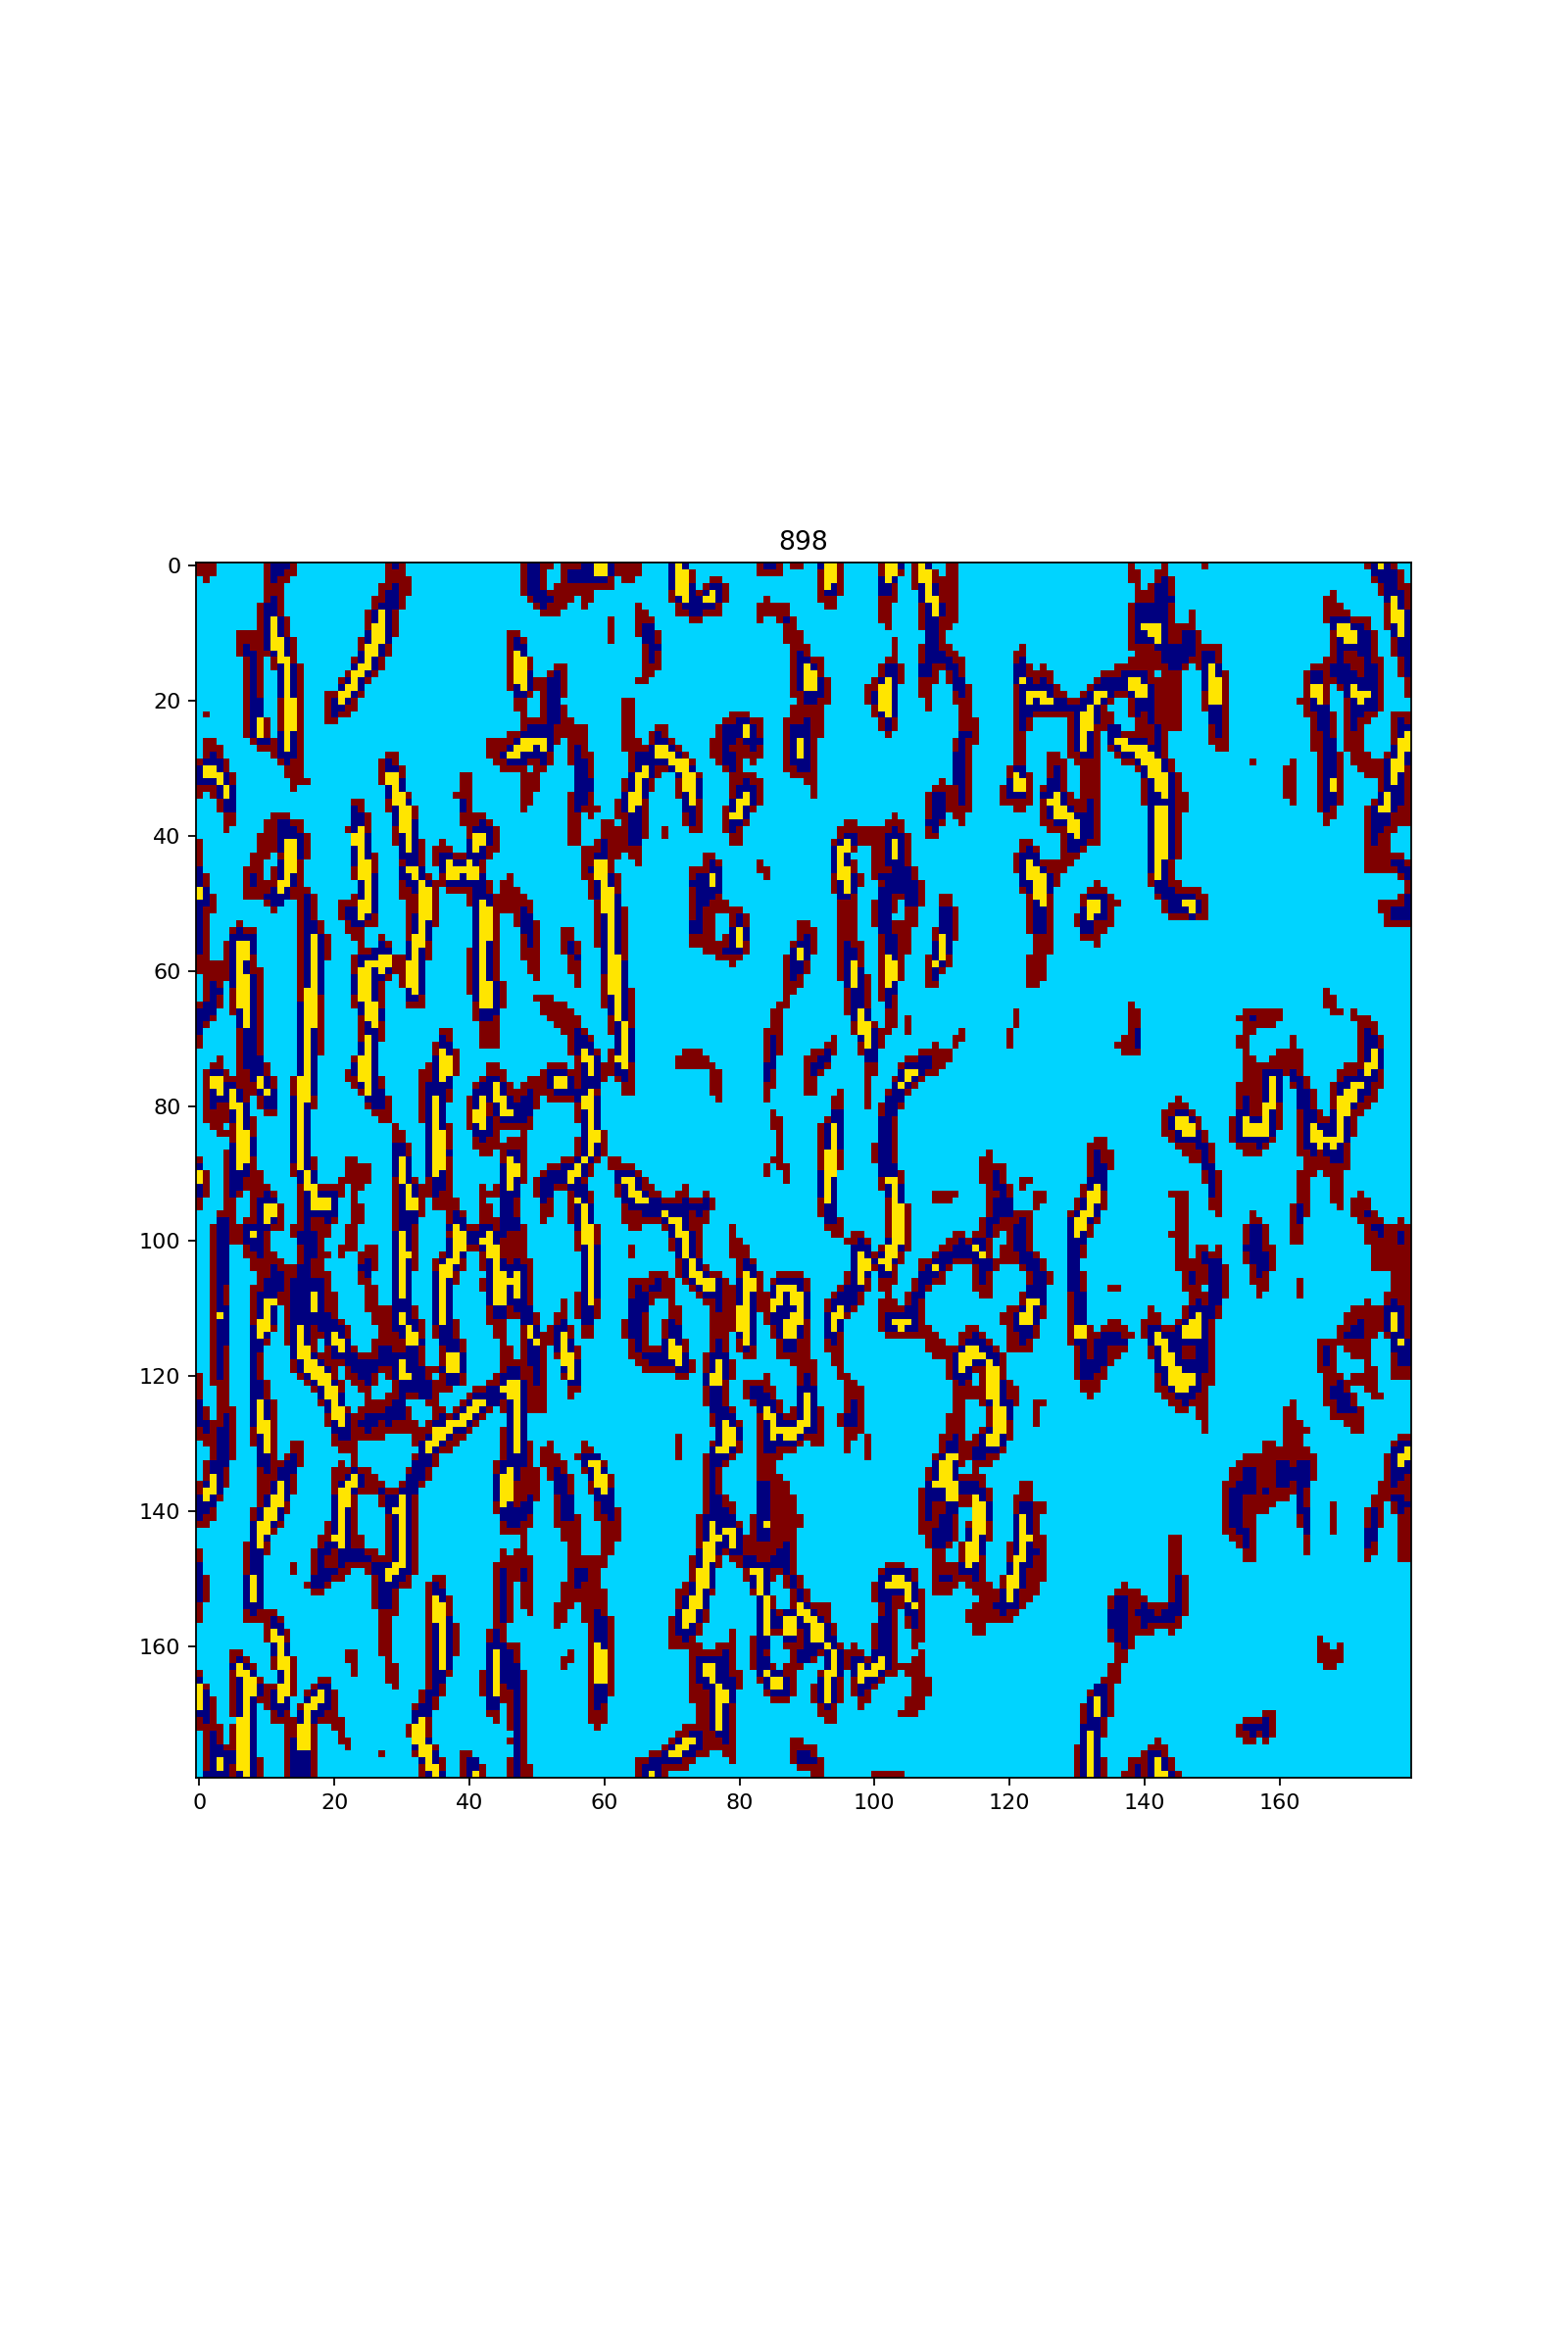

In [272]:
#########################################################
####### Animate All INLINE/ XLINE/ TIME SLICE   ########
#########################################################
%matplotlib notebook

fig = plt.figure(figsize=(10,15), dpi=80)
ax = fig.add_subplot(111)
plt.ion() 
fig.show()
fig.canvas.draw()
step = 2
for i in range(0,clusters1.shape[2],step):
    ax.clear()
    ax.imshow(clusters1[:,:,i].T, cmap="jet")  #  Showing timesclices with "step" increments
    plt.title(str(i))
    fig.canvas.draw()

<IPython.core.display.Javascript object>


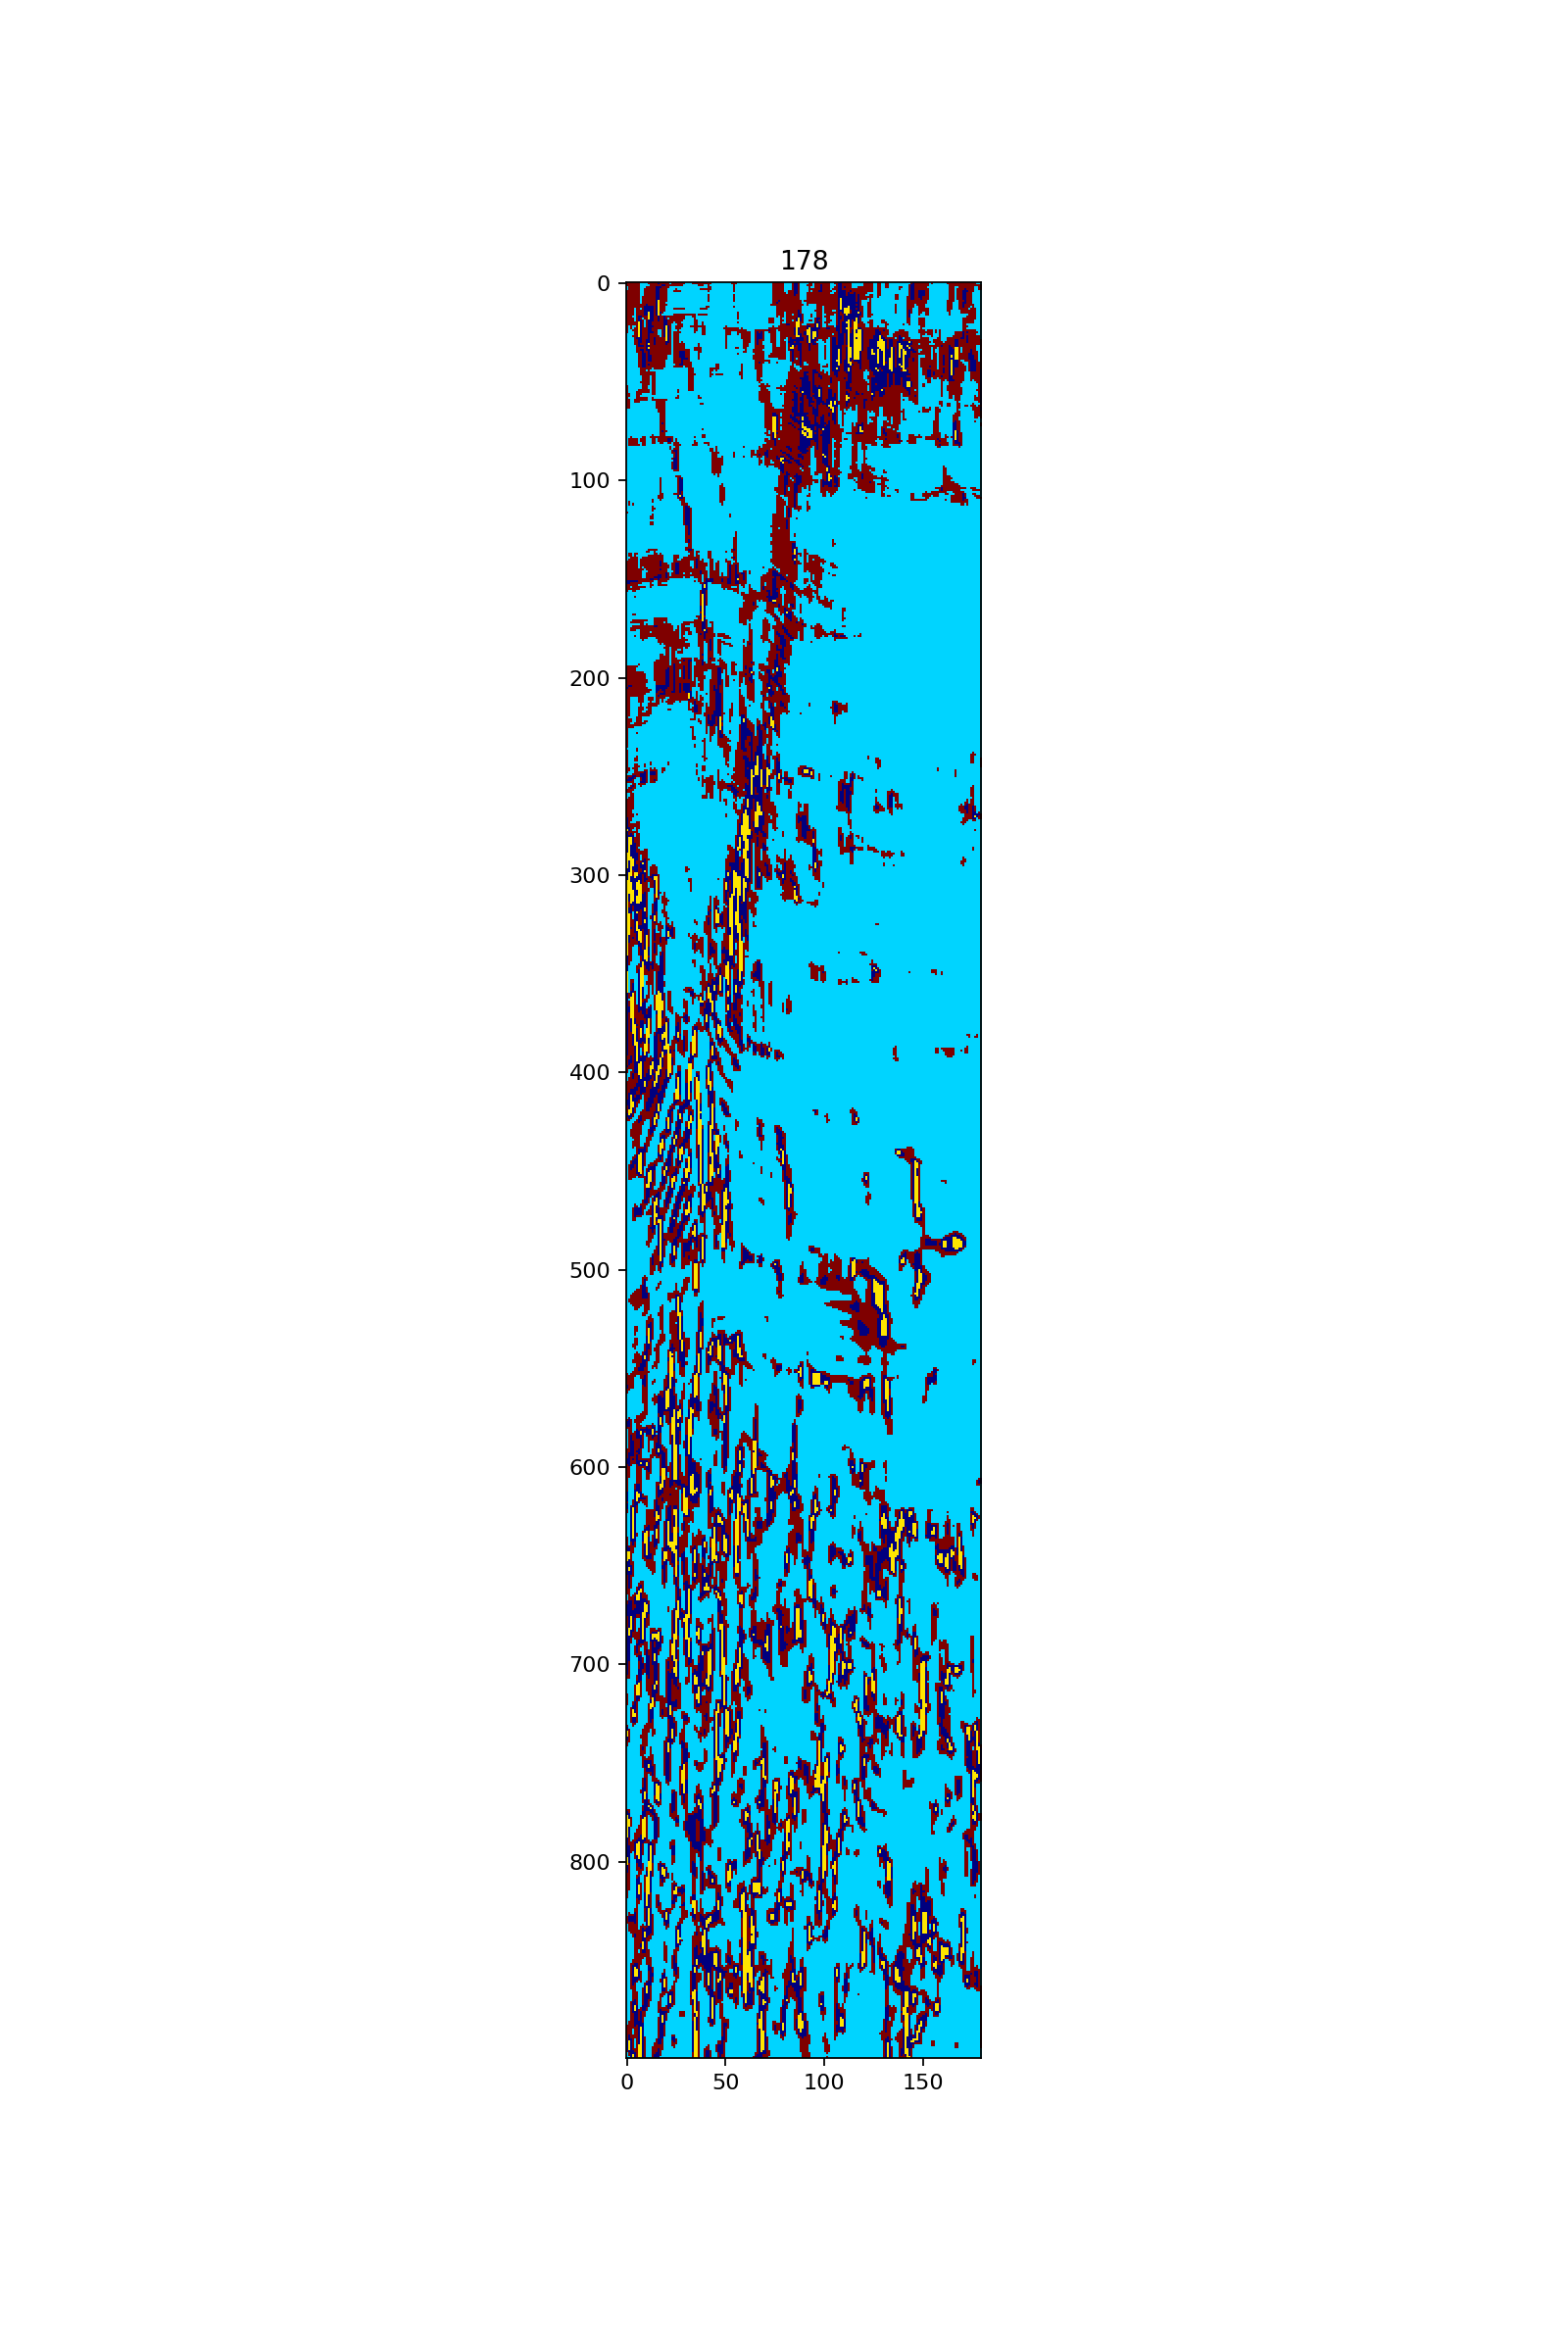

In [275]:
#########################################################
####### Animate All INLINE/ XLINE/ TIME SLICE   ########
#########################################################
%matplotlib notebook

fig = plt.figure(figsize=(10,15), dpi=80)
ax = fig.add_subplot(111)
plt.ion() 
fig.show()
fig.canvas.draw()
step = 2
for i in range(0,clusters1.shape[1],step):
    ax.clear()
    ax.imshow(clusters1[:,i,:].T, cmap="jet")  #  Showing timesclices with "step" increments
    plt.title(str(i))
    fig.canvas.draw()

## Write clustering results to SEGY format and upload to S3 
After running the clustering algorithm on the entire dataset, we will can write it as a segy file, and upload it into S3 bucket. 

In [232]:
spec = segyio.spec()
spec.sorting = 2
spec.format  = 1
clusters1=np.single(clusters1)

spec.ilines = list(range(clusters1.shape[0]))
spec.xlines = list(range(clusters1.shape[1]))
spec.samples = list(range(clusters1.shape[2]))
fsgy='kmeansresult.sgy'

with segyio.create(fsgy , spec) as f:

    # write the line itself to the file and the inline number in all this line's headers
    for ilno in spec.ilines:
        aaaa = clusters1[ilno,:,:]
        aaaa=np.float32(aaaa)
        f.iline[ilno] = aaaa
        f.header.iline[ilno] = { segyio.TraceField.INLINE_3D: ilno,
                                 segyio.TraceField.offset: 0
                               }
    # then do the same for xlines
    for xlno in spec.xlines:
        f.header.xline[xlno] = { segyio.TraceField.CROSSLINE_3D: xlno,
                                 segyio.TraceField.TRACE_SAMPLE_INTERVAL: 4000
                                }

In [239]:
def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel+'/'+filename
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)     
    return(url)

s3_train_loc = upload_to_s3(bucket = BUCKET_NAME, channel = 'output', filename = fsgy)

Writing to s3://sdu-machine-learning/kmeans_example_shellData/output/kmeansresult.sgy


### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
print(kmeans_predictor.endpoint)

import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

### (Optional) Reload and QC output SEGY
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

Starting SEG-Y decompressor


<IPython.core.display.Javascript object>


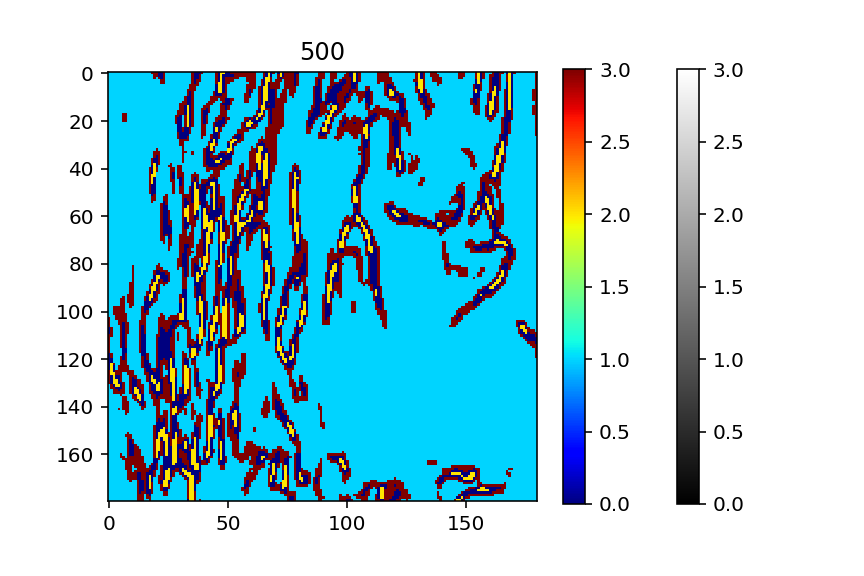

Finished using the SEG-Y decompressor


In [241]:
segy_objSD = segy_decomp(segy_file = fsgy,
               plot_data = True,
               read_direc = 'xline',
               inp_res = np.float32) 

In [245]:
#########################################################
#######     PLOT ONE INLINE/ XLINE/ TIME SLICE   ########
#########################################################

# %matplotlib notebook
i=500
plt.imshow(segy_objSD.data[:,:,i].T, cmap="jet")
plt.colorbar()
plt.title(str(i))

print(segy_objSD.data.shape)

(180, 180, 900)


<IPython.core.display.Javascript object>


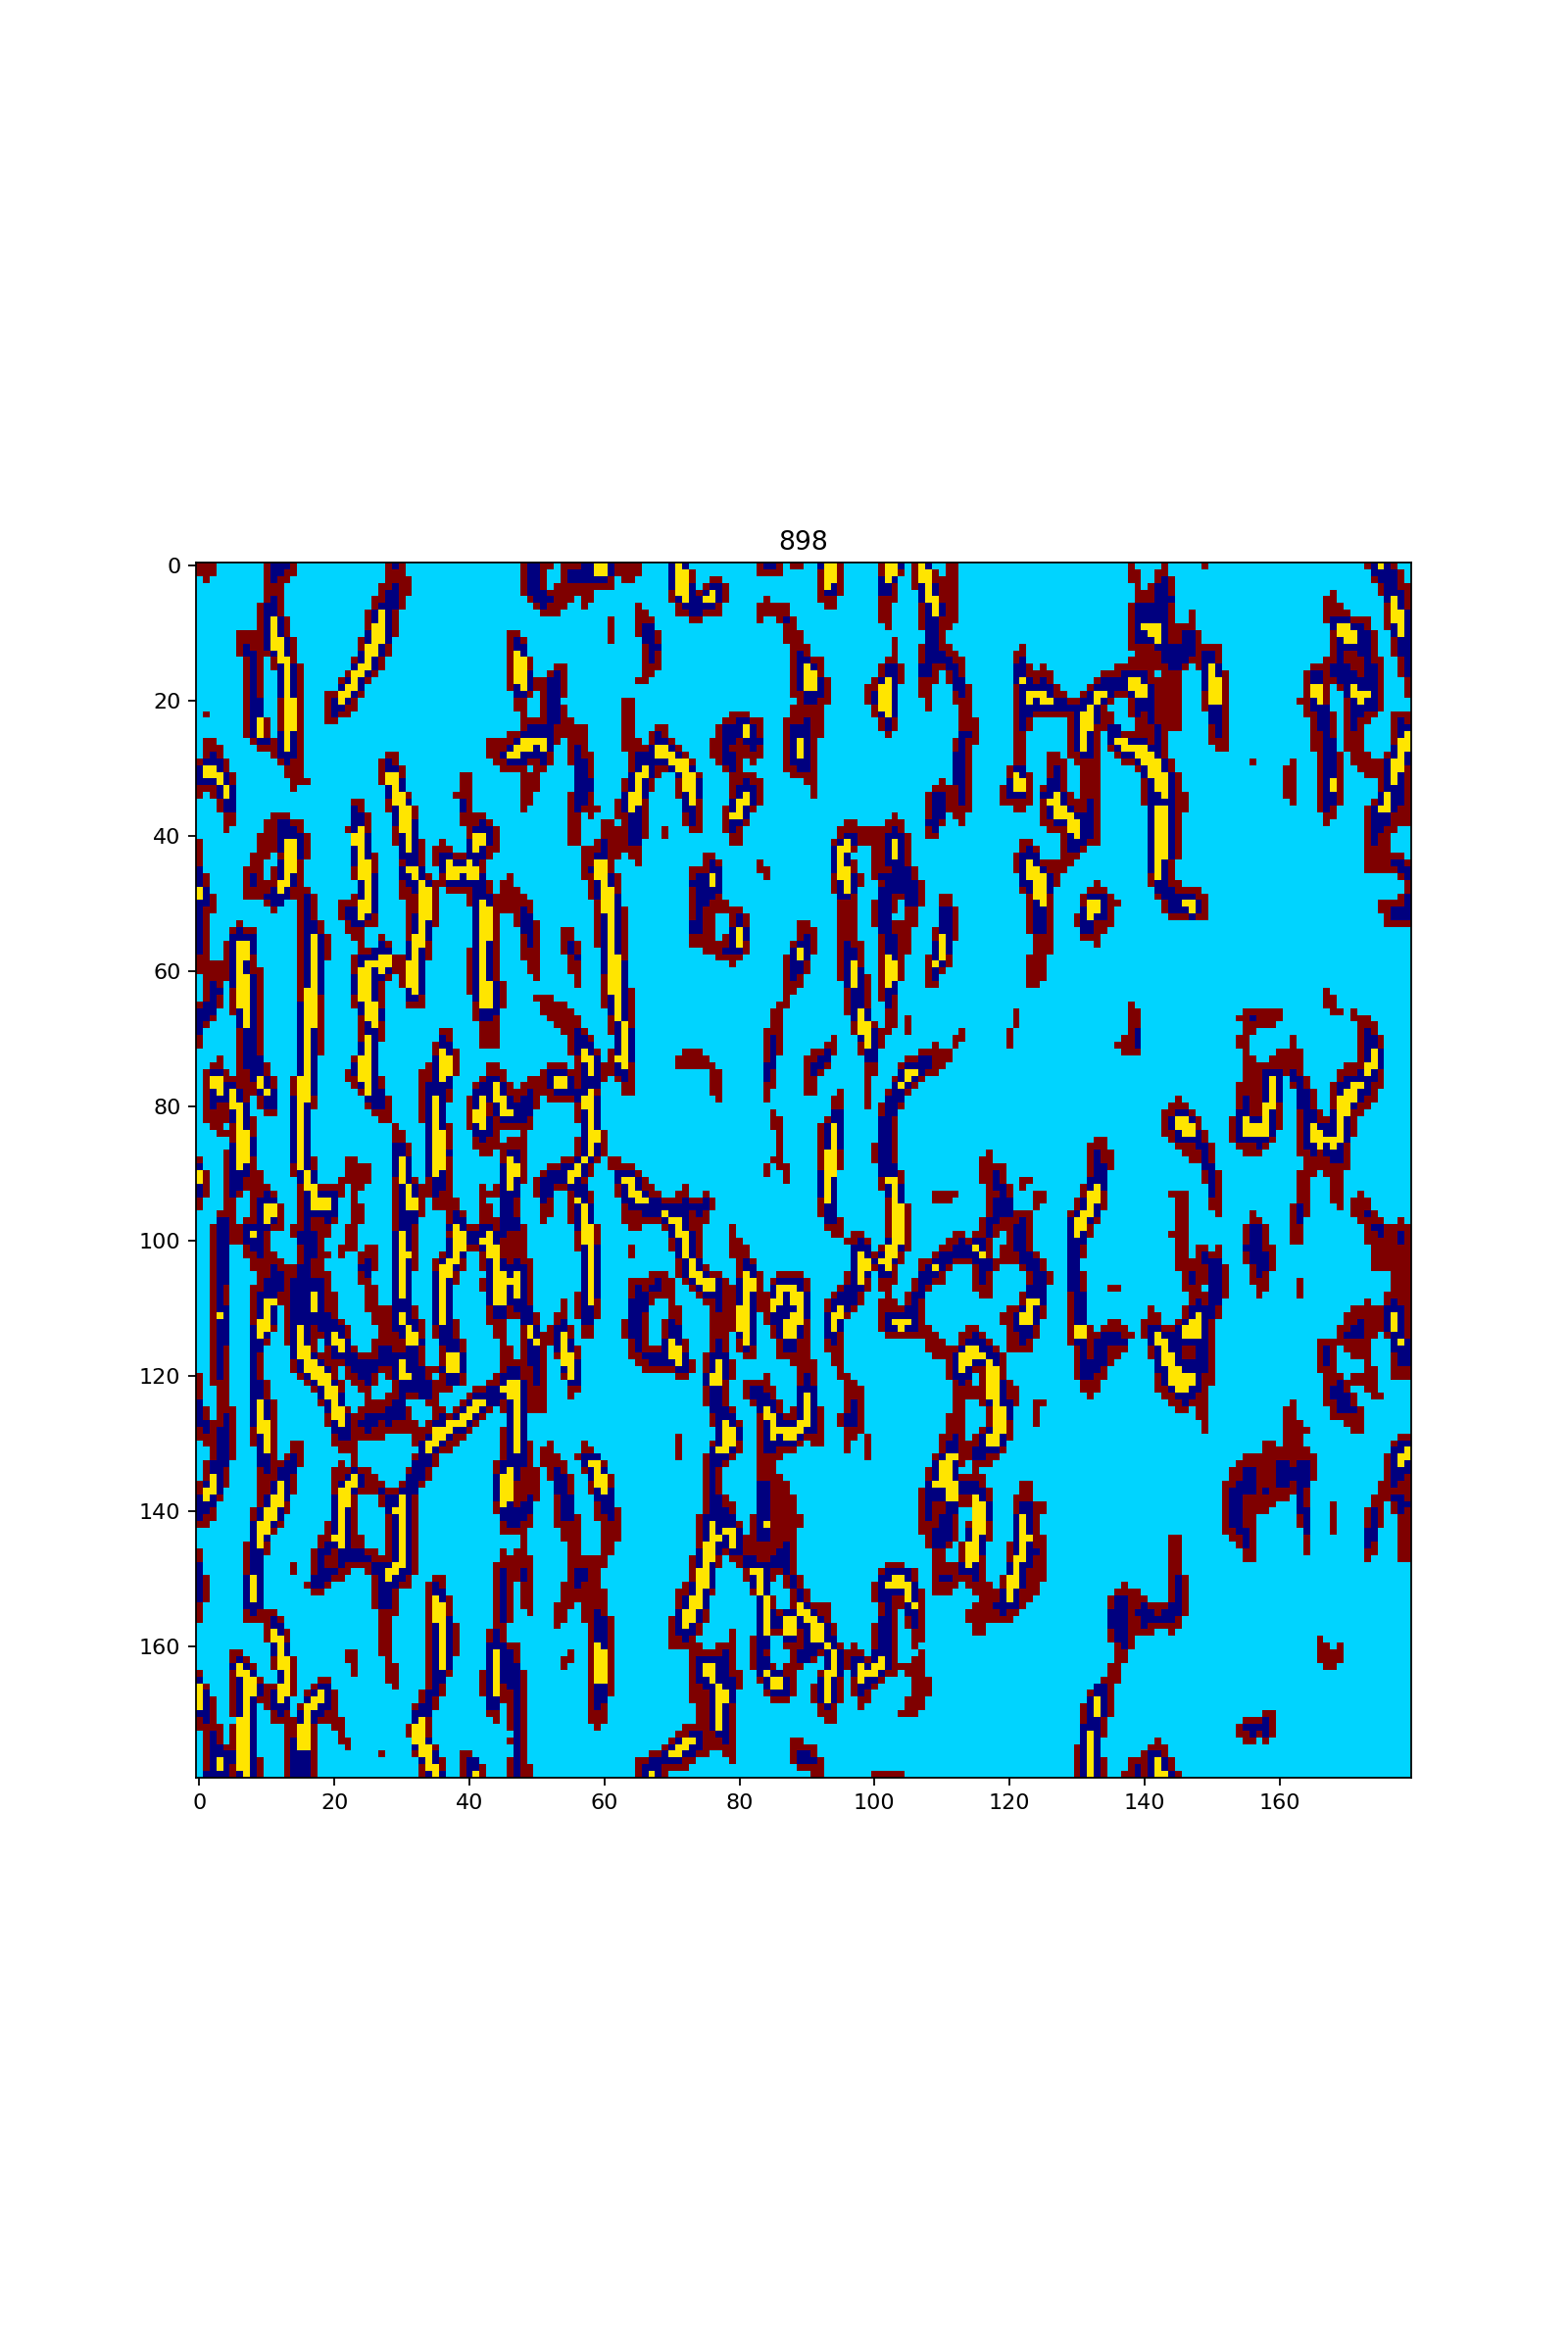

In [256]:
#########################################################
####### Animate All INLINE/ XLINE/ TIME SLICE   ########
#########################################################
%matplotlib notebook

fig = plt.figure(figsize=(10,15), dpi=80)
ax = fig.add_subplot(111)
plt.ion() 
fig.show()
fig.canvas.draw()
step = 2
for i in range(0,clusters1.shape[2],step):
    ax.clear()
    ax.imshow(segy_objSD.data[:,:,i].T, cmap="jet")  #  Showing timesclices with "step" increments
    plt.title(str(i))
    fig.canvas.draw()